# Knowledge Distillation in MHIST Dataset

In [15]:
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

plt.style.use('_mpl-gallery')

from Utilities import *

# Load dataset

In [6]:
# Prepare data
path = "mhist_dataset/images"
CSVfile = "mhist_dataset/annotations.csv"

data, file_names = load_mhist_images(path)
X_train, y_train, X_test, y_test = loadMHIST(CSVfile,data)

# Data Augmentation
AugmentedData = []
AugmentedLabel = []
for i in range(len(X_train)):
    if((y_train[i]==(1,0)).all()):
        AugmentedData.append(cv2.rotate(X_train[i], cv2.ROTATE_90_CLOCKWISE))
        AugmentedLabel.append([1,0])
X_train = np.concatenate((X_train, AugmentedData))
y_train = np.concatenate((y_train, AugmentedLabel))
c = list(zip(X_train, y_train))

random.shuffle(c)

X_train, y_train = zip(*c)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
Train_Data, Train_Label, Test_Data, Test_Label = dataBatching(X_train, y_train, X_test, y_test)


630 1545


In [8]:
## Load Teacher Model
restNet = getresnetModel()

## Load Student Model for KD
mobileNetKD = getMobileNetModel()

## Load Student Model for from scratch training
mobileNet = getMobileNetModel()

# Train Teacher Model (Resnet)

In [9]:
## intial epochs at learning rate 0.0001
train_and_evaluate(restNet,Train_Data,Test_Data,Train_Label,Test_Label,10, 0.0001)
## Fine tune epochs at learning rate 0.00001
train_and_evaluate(restNet,Train_Data,Test_Data,Train_Label,Test_Label,25, 0.00001)


Epoch 1: Class_accuracy: 59.03%
Epoch 2: Class_accuracy: 42.86%
Epoch 1: 

KeyboardInterrupt: 

# Train Student Mobile Net using KD


In [12]:
## intial epochs
train_and_evaluate_mobileNet_using_KD(mobileNetKD,restNet,Train_Data,Test_Data,Train_Label,Test_Label, 0.5,4, 10, 0.001)
## Fine tune epochs
train_and_evaluate_mobileNet_using_KD(mobileNetKD,restNet,Train_Data,Test_Data,Train_Label,Test_Label, 0.5,4, 25, 0.0001)

Epoch 1: Class_accuracy: 61.21%
Epoch 2: Class_accuracy: 58.73%
Epoch 3: Class_accuracy: 35.71%
Epoch 4: Class_accuracy: 35.71%
Epoch 5: Class_accuracy: 37.50%
Epoch 6: Class_accuracy: 47.72%
Epoch 7: Class_accuracy: 47.92%
Epoch 8: Class_accuracy: 37.80%
Epoch 9: Class_accuracy: 42.46%
Epoch 10: Class_accuracy: 50.69%
Epoch 1: Class_accuracy: 41.27%
Epoch 2: Class_accuracy: 43.15%
Epoch 3: Class_accuracy: 41.47%
Epoch 4: Class_accuracy: 41.96%
Epoch 5: Class_accuracy: 41.47%
Epoch 6: Class_accuracy: 41.57%
Epoch 7: 

KeyboardInterrupt: 

# Train another student model from scratch

In [13]:
## intial epochs
train_and_evaluate(mobileNet,Train_Data,Test_Data,Train_Label,Test_Label,10, 0.001)
## Fine tune epochs
train_and_evaluate(mobileNet,Train_Data,Test_Data,Train_Label,Test_Label,25, 0.0001)


Epoch 1: Class_accuracy: 59.23%
Epoch 2: Class_accuracy: 59.82%
Epoch 3: Class_accuracy: 38.29%
Epoch 4: Class_accuracy: 37.70%
Epoch 5: Class_accuracy: 58.73%
Epoch 6: Class_accuracy: 45.44%
Epoch 7: Class_accuracy: 39.29%
Epoch 8: Class_accuracy: 37.10%
Epoch 9: Class_accuracy: 47.72%
Epoch 10: Class_accuracy: 55.95%
Epoch 1: Class_accuracy: 41.87%
Epoch 2: Class_accuracy: 41.57%
Epoch 3: Class_accuracy: 41.96%
Epoch 4: Class_accuracy: 41.96%
Epoch 5: Class_accuracy: 41.67%
Epoch 6: Class_accuracy: 41.67%
Epoch 7: 

KeyboardInterrupt: 

# Models Testing

In [18]:
# model testing
teacherAcc = testTransferedModel(restNet,Test_Data,Test_Label)
studentAcc = testTransferedModel(mobileNet,Test_Data,Test_Label)
studentAccKD = testTransferedModel(mobileNetKD,Test_Data,Test_Label)

model Testing Accuracy: 39.68%
tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
5
tf.Tensor(5.0, shape=(), dtype=float32)
27


# Temperature Vs Accuracy

In [ ]:
testACC = []
tempratureValues = [1, 2, 4, 16, 32, 64]
for temp in tempratureValues:
    st = getMobileNetModel()
    train_and_evaluate_mobileNet_using_KD(st,restNet,Train_Data,Test_Data,Train_Label,Test_Label, 0.5,temp, 10, 0.001)
    train_and_evaluate_mobileNet_using_KD(st,restNet,Train_Data,Test_Data,Train_Label,Test_Label, 0.5,temp, 25, 0.0001)
    testACC += [testTransferedModel(st,Test_Data,Test_Label)]
print(testACC)

Epoch 1: Class_accuracy: 35.71%
Epoch 1: Class_accuracy: 38.69%
Epoch 2: Class_accuracy: 35.62%
model Testing Accuracy: 35.62%
Epoch 1: Class_accuracy: 35.71%
Epoch 1: Class_accuracy: 44.15%
Epoch 2: Class_accuracy: 35.81%
model Testing Accuracy: 35.81%
Epoch 1: Class_accuracy: 35.71%
Epoch 1: Class_accuracy: 35.71%
Epoch 2: Class_accuracy: 35.71%
model Testing Accuracy: 35.71%
Epoch 1: Class_accuracy: 35.71%
Epoch 1: Class_accuracy: 35.71%
Epoch 2: Class_accuracy: 35.71%
model Testing Accuracy: 35.71%
Epoch 1: Class_accuracy: 35.71%
Epoch 1: Class_accuracy: 35.71%
Epoch 2: Class_accuracy: 35.71%
model Testing Accuracy: 35.71%
Epoch 1: Class_accuracy: 35.71%
Epoch 1: Class_accuracy: 35.71%
Epoch 2: Class_accuracy: 35.71%
model Testing Accuracy: 35.71%
[<tf.Tensor: shape=(), dtype=float32, numpy=35.61508>, <tf.Tensor: shape=(), dtype=float32, numpy=35.81349>, <tf.Tensor: shape=(), dtype=float32, numpy=35.714287>, <tf.Tensor: shape=(), dtype=float32, numpy=35.714287>, <tf.Tensor: shape=(

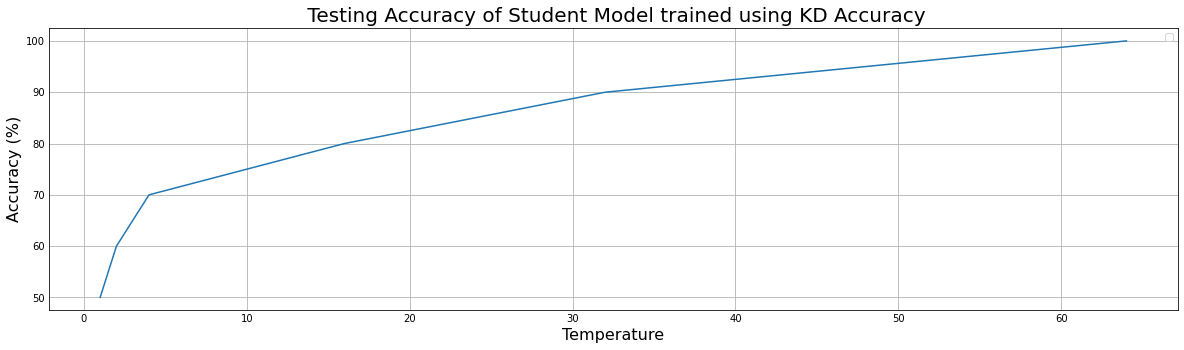

In [16]:
f, ax = plt.subplots(figsize=(16, 4))
tempratureValues = [1, 2, 4, 16, 32, 64]
testACC = [50, 60 , 70, 80 , 90, 100]
ax.plot(tempratureValues,testACC )
ax.set_xlabel('Temperature', fontsize = 16)
ax.set_ylabel('Accuracy (%)', fontsize = 16)
ax.set_title(' Testing Accuracy of Student Model trained using KD Accuracy', fontsize = 20)
ax.legend()
plt.show()
f.savefig('Figures/fig7.png', bbox_inches='tight')

In [19]:
# your code start from here for step 8
from keras_flops import get_flops
TeacherParameters = restNet.summary()
StudentParameters = mobileNetKD.summary()

flops = get_flops(restNet, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

flops = get_flops(mobileNetKD, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


FLOPS: 6.99 G
FLOPS: 0.613 G
